In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Compute the derivative of ReLU for backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Define the Softmax activation function
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

# Calculate the cross-entropy loss
def cross_entropy_loss(y_pred, y_true):
    n_samples = y_true.shape[0]
    log_p = -np.log(y_pred[range(n_samples), y_true])
    loss = np.sum(log_p) / n_samples
    return loss

# Derivative of the cross-entropy loss with respect to the Softmax output
def cross_entropy_derivative(y_pred, y_true):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true] -= 1
    grad = grad / n_samples
    return grad

# Calculate the accuracy of predictions
def accuracy(y_pred, y_true):
    predictions = np.argmax(y_pred, axis=1)
    return np.mean(predictions == y_true)

# Neural Network class with momentum and RMSProp updates
class NeuralNetwork:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, beta=0.9, rho=0.9, epsilon=1e-8):
        # Initialize weights using He initialization
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
        self.b3 = np.zeros((1, output_size))

        # Initialize velocity terms for momentum and squared gradients for RMSProp
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        self.vW3 = np.zeros_like(self.W3)
        self.vb3 = np.zeros_like(self.b3)
        self.sqW1 = np.zeros_like(self.W1)
        self.sqW2 = np.zeros_like(self.W2)
        self.sqW3 = np.zeros_like(self.W3)
        self.sqB1 = np.zeros_like(self.b1)
        self.sqB2 = np.zeros_like(self.b2)
        self.sqB3 = np.zeros_like(self.b3)

        self.beta = beta  # Momentum factor
        self.rho = rho    # RMSProp decay factor
        self.epsilon = epsilon  # Small constant to avoid division by zero

    def forward(self, X):
        # Perform the forward pass
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = softmax(self.Z3)

        return self.A3

    def backprop(self, X, y, output):
        # Perform backpropagation to compute gradients
        m = y.shape[0]

        # Calculate gradient for the output layer
        dZ3 = cross_entropy_derivative(output, y)
        dW3 = np.dot(self.A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Compute gradients for the second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Compute gradients for the first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3

    def update_parameters_rmsprop(self, dW1, db1, dW2, db2, dW3, db3, learning_rate):
        # Update the squared gradient accumulators using RMSProp
        self.sqW1 = self.rho * self.sqW1 + (1 - self.rho) * np.square(dW1)
        self.sqB1 = self.rho * self.sqB1 + (1 - self.rho) * np.square(db1)
        self.sqW2 = self.rho * self.sqW2 + (1 - self.rho) * np.square(dW2)
        self.sqB2 = self.rho * self.sqB2 + (1 - self.rho) * np.square(db2)
        self.sqW3 = self.rho * self.sqW3 + (1 - self.rho) * np.square(dW3)
        self.sqB3 = self.rho * self.sqB3 + (1 - self.rho) * np.square(db3)

        # Update weights and biases using RMSProp
        self.W1 -= learning_rate * dW1 / (np.sqrt(self.sqW1) + self.epsilon)
        self.b1 -= learning_rate * db1 / (np.sqrt(self.sqB1) + self.epsilon)
        self.W2 -= learning_rate * dW2 / (np.sqrt(self.sqW2) + self.epsilon)
        self.b2 -= learning_rate * db2 / (np.sqrt(self.sqB2) + self.epsilon)
        self.W3 -= learning_rate * dW3 / (np.sqrt(self.sqW3) + self.epsilon)
        self.b3 -= learning_rate * db3 / (np.sqrt(self.sqB3) + self.epsilon)

def train(X_train, y_train, X_test, y_test, nn, epochs, learning_rate, batch_size=32, use_rmsprop=False):
    m = X_train.shape[0]

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Shuffle the training data at each epoch
        indices = np.random.permutation(m)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        # Train in batches
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Forward pass
            output = nn.forward(X_batch)

            # Compute the training loss
            loss = cross_entropy_loss(output, y_batch)

            # Backpropagation to compute gradients
            dW1, db1, dW2, db2, dW3, db3 = nn.backprop(X_batch, y_batch, output)

            # Update the network parameters
            if use_rmsprop:
                nn.update_parameters_rmsprop(dW1, db1, dW2, db2, dW3, db3, learning_rate)
            else:
                nn.update_parameters(dW1, db1, dW2, db2, dW3, db3, learning_rate)

        # Evaluate the performance at the end of each epoch
        train_output = nn.forward(X_train)
        train_loss = cross_entropy_loss(train_output, y_train)
        train_accuracy = accuracy(train_output, y_train)

        test_output = nn.forward(X_test)
        test_loss = cross_entropy_loss(test_output, y_test)
        test_accuracy = accuracy(test_output, y_test)

        # Store the results
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print progress every 10 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}, '
                  f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Load the training and testing datasets from CSV files
x_train = pd.read_csv('Task_2/x_train.csv').values
y_train = pd.read_csv('Task_2/y_train.csv').values.flatten()
x_test = pd.read_csv('Task_2/x_test.csv').values
y_test = pd.read_csv('Task_2/y_test.csv').values.flatten()

# Set parameters for the neural network
input_size = x_train.shape[1]
hidden1_size = 100
hidden2_size = 40
output_size = 4
epochs = 500

# List of learning rates to try
learning_rates = [1, 0.1, 0.01, 0.001]
train_losses = {}
test_losses = {}
train_accuracies = {}
test_accuracies = {}

# Train the neural network with different learning rates using RMSProp
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    nn = NeuralNetwork(input_size, hidden1_size, hidden2_size, output_size)
    tr_loss, te_loss, tr_acc, te_acc = train(x_train, y_train, x_test, y_test, nn, epochs, lr, use_rmsprop=True)

    train_losses[lr] = tr_loss
    test_losses[lr] = te_loss
    train_accuracies[lr] = tr_acc
    test_accuracies[lr] = te_acc


Training with learning rate: 1


c:\Users\sajee\miniconda3\envs\dnn-assignment\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Epoch 100/500, Train Loss: 1.6219762010710155, Test Loss: 1.6261821301738566, Train Accuracy: 0.2844498702884175, Test Accuracy: 0.28876678876678874
Epoch 200/500, Train Loss: 1.5503945054077934, Test Loss: 1.5532974125792682, Train Accuracy: 0.2758278650999542, Test Accuracy: 0.2777777777777778
Epoch 300/500, Train Loss: 1.4261393918033116, Test Loss: 1.4281521334338934, Train Accuracy: 0.2844498702884175, Test Accuracy: 0.28876678876678874
Epoch 400/500, Train Loss: 1.5297265996674863, Test Loss: 1.5201396202392106, Train Accuracy: 0.2844498702884175, Test Accuracy: 0.28876678876678874
Epoch 500/500, Train Loss: 1.79303772887626, Test Loss: 1.7833213892580642, Train Accuracy: 0.2844498702884175, Test Accuracy: 0.28876678876678874
Training with learning rate: 0.1
Epoch 100/500, Train Loss: 1.3979509880527194, Test Loss: 1.3980720631101728, Train Accuracy: 0.2758278650999542, Test Accuracy: 0.2777777777777778
Epoch 200/500, Train Loss: 1.3865678232241565, Test Loss: 1.388417125731474, 

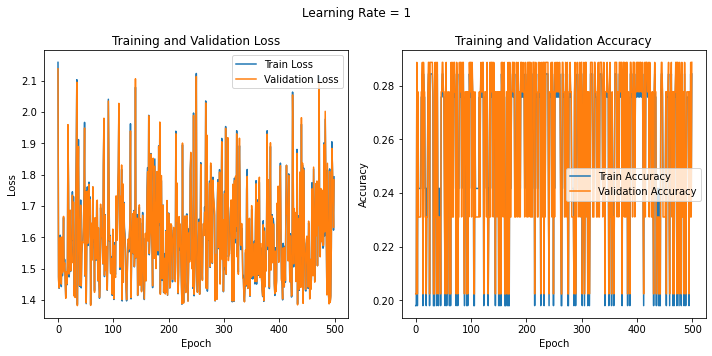

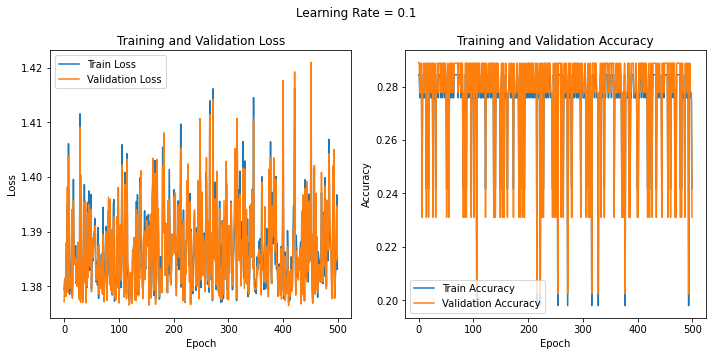

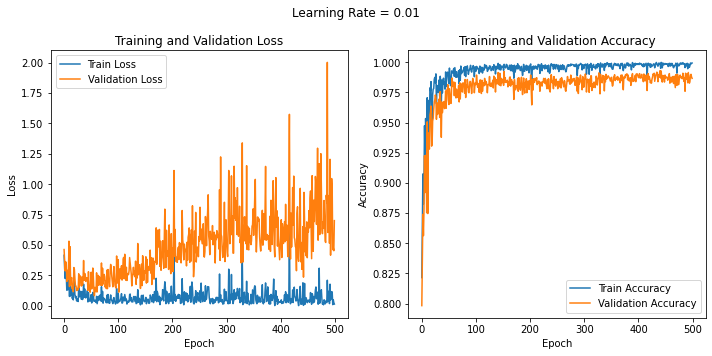

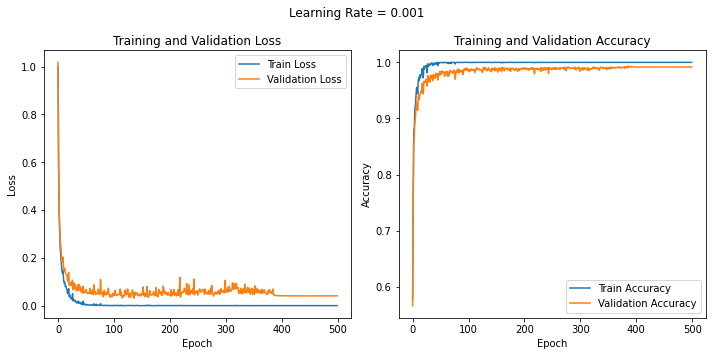

In [4]:
import matplotlib.pyplot as plt

learning_rates = [1, 0.1, 0.01,0.001]
epochs_range = range(epochs)

for lr in learning_rates:

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Learning Rate = {lr}")
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[lr], label="Train Loss")
    plt.plot(test_losses[lr], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot the accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies[lr], label="Train Accuracy")
    plt.plot(test_accuracies[lr], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()